What if we just used locally weighted linear regression for modeling nonlinear systems instead of using something like a neural network?

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [4]:
states = np.load('data_msd/states1-3-0.1-nonlinear.npy')
forces = np.load('data_msd/forces1-3-0.1-nonlinear.npy')

- states[t = 0] - states[t = T+1]
- forces[t = 0] - forces[t = T]

lets test if the previous method would work

In [5]:
states_std = np.std(states,axis=0)
forces_std = np.std(forces,axis=0)

states_mean = np.array([0,0])
forces_mean = np.array([0])

In [6]:
states_norm = (states-states_mean)/states_std
forces_norm = (forces-forces_mean)/forces_std

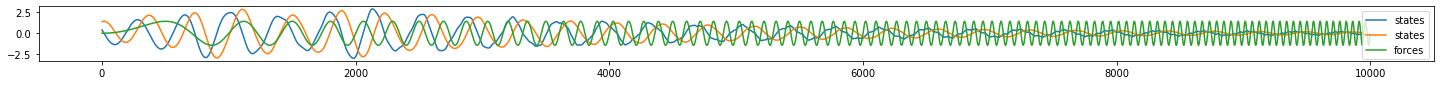

In [7]:
plt.figure(figsize=(25,1))
plt.plot(range(states_norm.shape[0]-1),states_norm[:-1],label = 'states')
plt.plot(range(forces_norm.shape[0]),forces_norm, label = 'forces')
plt.legend()
plt.show()

In [147]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.INPUT = 3
        self.OUTPUT = 2
        self.HIDDEN = 100
        self.fc_1 = nn.Sequential(nn.Linear(self.INPUT,self.HIDDEN),nn.ReLU(),nn.Dropout())
        self.fc_2 = nn.Linear(self.HIDDEN,self.OUTPUT)
    
    def forward(self,x):
        x = self.fc_1(x)
        x = self.fc_2(x)
        return x

In [183]:
net = Net()
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

The output from the network will be fed back into the input for a number of sequence and the error is then calculated at the end of sequence, compared to the actual state after that number of sequence. 
- But what should the length of the sequence be?
- 1 doesn't work. 
- lets try 100

In [184]:
states_tensor = torch.Tensor(states_norm)
forces_tensor = torch.Tensor(forces_norm)

In [ ]:
MAX_DEPTH = 3
LAST_START = states_tensor.shape[0]-MAX_DEPTH
LAST_START = 1000
EPOCH = 100

import time

net.train()

for epoch in range(EPOCH):
    for start in range(LAST_START):
        previous_state = torch.cat((states_tensor[start],forces_tensor[start].view(1)),dim=0)
        optimizer.zero_grad()
        for depth in range(MAX_DEPTH):
            next_state = net(previous_state)

            loss = loss_function(next_state,states_tensor[start+depth+1])
            loss.backward()

            previous_state = torch.cat((next_state.detach(),forces_tensor[start+depth+1].view(1)),dim=0)
            
            optimizer.step()
        clear_output()
    print("EPOCH",epoch,"loss",loss)

In [ ]:
X = np.append(states_norm[:-1],forces_norm[:,np.newaxis],axis=1)
X_tensor = torch.Tensor(X)

y = states_norm[1:]
y_tensor = torch.Tensor(y)

In [ ]:
net.eval()
with torch.no_grad():
    output = net(X_tensor[:2000])
    

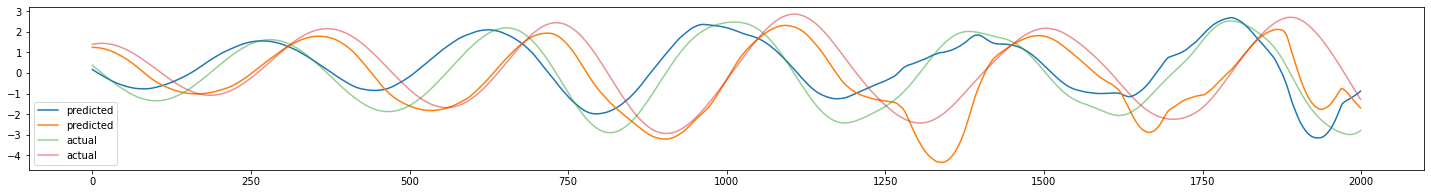

In [194]:
plt.figure(figsize=(25,3))
plt.plot(range(output.shape[0]),output,label = 'predicted')
plt.plot(range(output.shape[0]),y_tensor[:output.shape[0]], label = 'actual',alpha=0.5)
plt.legend()
plt.show()

In [68]:
time = np.linspace(0,100,10000,endpoint = False)

initial_states = torch.Tensor(np.array([1/states_std[0],-1/states_std[1]]))
simulated_forces = torch.Tensor(np.sin(time)/forces_std)

In [69]:
simulated_states = []

simulated_output = initial_states
net.eval()
with torch.no_grad():
    for i in range(len(simulated_forces)):
        inp = torch.cat((simulated_output,torch.Tensor([simulated_forces[i]])),dim=0)
        simulated_output = net(inp)
        simulated_states.append(simulated_output.numpy())

In [70]:
simulated_states = np.array(simulated_states)
simulated_states = simulated_states*states_std

In [71]:
simulated_states

array([[-0.46935035,  0.40882789],
       [-1.00869857, -0.41227182],
       [-0.70650174, -0.47310678],
       ...,
       [-0.92274363, -0.30744264],
       [-0.91946488, -0.30801368],
       [-0.91616608, -0.30858797]])

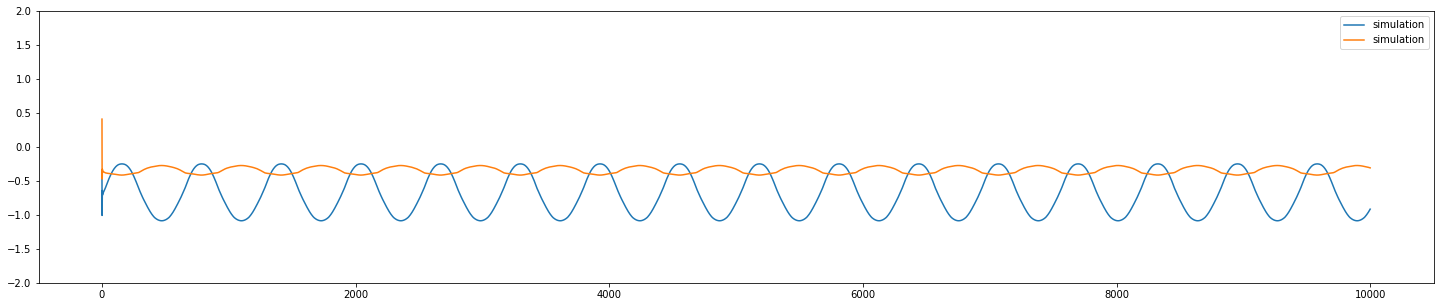

In [72]:
plt.figure(figsize=(25,5))
plt.plot(range(simulated_states.shape[0]),simulated_states,label='simulation')
plt.ylim([-2,2])
plt.legend()
plt.show()


